In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# 0.) Clean the Apple Data to get a quarterly series of EPS.

In [2]:
y = pd.read_csv('AAPL_quarterly_financials.csv')

In [3]:
# 将 DataFrame 的索引设置为 name 列
y.index = y.name

In [4]:
# 选择基本每股收益（Basic EPS）作为分析的目标，并且去除前两行（可能是非数据行，如标题或总结）
y = pd.DataFrame(y.loc["BasicEPS",:]).iloc[2:,:]

In [5]:
y.index = pd.to_datetime(y.index) # 将索引转换为 datetime 对象，以便于时间序列分析

In [6]:
y = y.fillna(0.).sort_index() # 填充缺失值为 0 并按时间排序

# 2.) Normalize all the X data

In [7]:
# 使用 TrendReq 创建 pytrends 对象，设置语言和时区
from pytrends.request import TrendReq

In [9]:
# 定义一个关键词列表和时间范围，用于检索 Google Trends 数据
# 设置语言为英文（hl='en-US'），时区为 UTC+6（tz=360）
pytrends = TrendReq(hl='en-US', tz=360)

# 设定关键词和时间范围
keywords = ["MacBook","iPhone","iPad","Apple Layoffs","Sales","Apple Share Price",
            "Recession","Policy","Taylor Swift Tickets","Is the Earth Flat","Hospital"]  # Add your keywords here
start_date = '2004-01-01'
end_date = '2024-01-01'

# 遍历每个关键词，使用 pytrends 获取指定时间范围内的趋势数据，并将结果存储在 DataFrame df 中

# Create an empty DataFrame to store the results
df = pd.DataFrame()

# Iterate through keywords and fetch data
for keyword in keywords:
    pytrends.build_payload([keyword], cat=0, timeframe=f'{start_date} {end_date}', geo='', gprop='')
    interest_over_time_df = pytrends.interest_over_time()
    df[keyword] = interest_over_time_df[keyword]

In [10]:
# 重采样为季度数据：将 Google Trends 数据按季度重采样，并计算每个季度的平均值，以便与季度财务数据匹配
X = df.resample("Q").mean()

#合并数据：将财务数据（y）和重采样后的 Google Trends 数据（X）合并，并丢弃任何包含缺失值的行。
temp = pd.concat([y,X],axis=1).dropna()

# 分离特征和目标变量:从合并后的数据中分离出目标变量（BasicEPS）和特征（Google Trends 数据）
y = temp[["BasicEPS"]].copy()
X = temp.iloc[:,1:].copy()

In [11]:
# 标准化特征数据
# 使用 StandardScaler 对特征数据进行标准化处理，确保每个特征具有 0 均值和单位方差，有利于模型训练的稳定性和效果
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 4.) Run a Lasso with lambda of .5. Plot a bar chart.

In [12]:
# 应用 Lasso 回归：能够通过将一些系数压缩到 0 来实现特征选择

from sklearn.linear_model import Lasso
lasso = Lasso(alpha = .1) # alpha=0.1 是正则化强度参数
lasso.fit(X_scaled,y)
coefficients = lasso.coef_

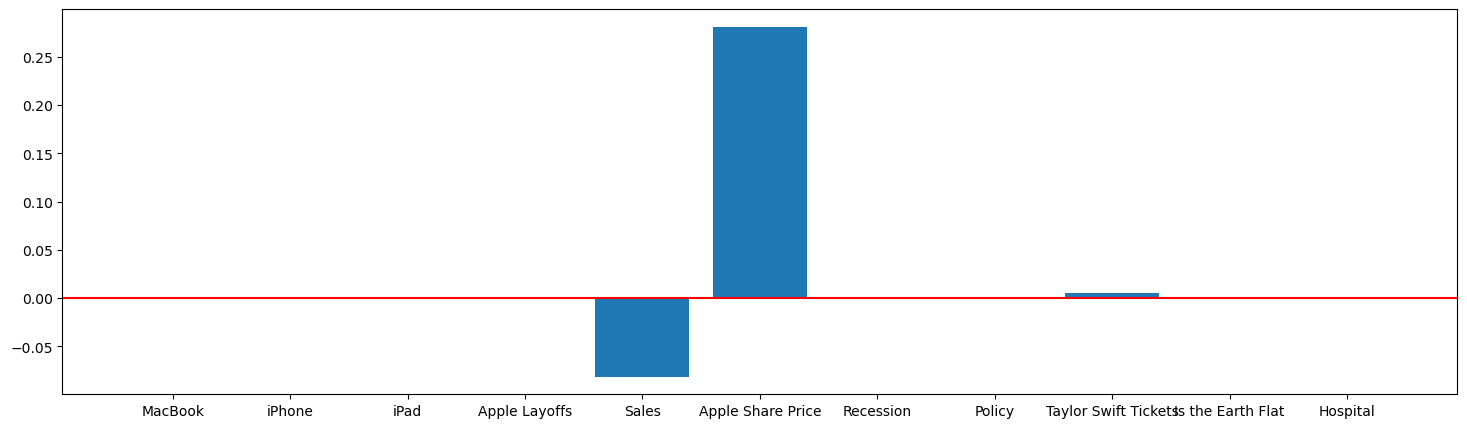

In [13]:
# 获取和可视化系数：提取 Lasso 回归模型的系数，并使用柱状图进行可视化
# 红色水平线表示系数值为 0 的参考线，非零系数的特征可能对目标变量有重要影响
plt.figure(figsize = (18,5))
plt.bar(range(len(coefficients)),coefficients,tick_label=X.columns)
plt.axhline(0.,color = "red")
plt.show()

Lasso回归，全称为Least Absolute Shrinkage and Selection Operator回归，是一种在回归模型中进行变量选择和复杂度调整的技术，以提高模型的预测精度和解释能力。Lasso通过在损失函数中加入一个L1惩罚项（即系数的绝对值之和）来实现这一目标。这种方法可以将一些不重要特征的系数压缩至0，从而实现变量选择的目的。


### 有何意义：

Lasso回归的重要性主要体现在以下几个方面：

- **变量选择**：通过将不重要的特征系数压缩至0，Lasso帮助识别对模型预测最有影响力的变量，简化模型并减少过拟合的风险。
- **模型解释性**：简化后的模型只包含有影响的特征，提高了模型的可解释性，有助于理解哪些变量是影响目标变量的关键因素。
- **处理多重共线性**：当数据中存在高度相关的特征时，Lasso可以通过将一些相关特征的系数压缩至0来减轻多重共线性问题。

总之，Lasso回归是一种强大的回归分析工具，它不仅可以提高模型的预测性能，还可以通过变量选择和模型简化来提升模型的解释性。

In [ ]:
#如何实现：

# 1. 导入Lasso回归
from sklearn.linear_model import Lasso

# 2. 创建Lasso回归模型
lasso = Lasso(alpha=0.1)
# 这里创建了一个Lasso回归对象`lasso`，`alpha`参数控制L1惩罚的强度。`alpha`的值越大，施加的惩罚越强，更多的系数会被压缩至0。

# 3. 训练模型
lasso.fit(X_scaled, y)
# 使用标准化后的特征数据`X_scaled`和目标变量`y`来训练Lasso回归模型
# 训练过程中，模型会学习每个特征对目标变量的影响，同时施加L1惩罚以减少模型复杂度

# 4. 获取系数
coefficients = lasso.coef_
# 训练完成后，可以通过`coef_`属性获取模型学习到的系数。在Lasso回归中，一些不重要的特征系数会被压缩至0。

# 5. 可视化系数
plt.bar(range(len(coefficients)), coefficients, tick_label=X.columns)
# 通过绘制柱状图，直观展示每个特征的系数大小。系数为0的特征可以认为对模型的预测没有贡献，因此可以被视为非重要特征。

# 5.) Do these coefficient magnitudes make sense?

# 6.) Run a for loop looking at 10 different Lambdas and plot the coefficient magnitude for each.

# 7.) Run a cross validation. What is your ideal lambda?